![MLU Logo](../data/MLU_Logo.png)

# Assignment 2

## Related Reading
If you want to read more about these concepts, I'll be putting links here for you to find verious resources.
* [Understanding Random Forests](https://arxiv.org/pdf/1407.7502) Sections 4.1 and 4.2. *Bias-Variance Decomposition, and Ensembling Methods Based on Randomness*
* A deeper dive into [Unified approaches to the Bias-Variance Decomposition](https://homes.cs.washington.edu/~pedrod/papers/mlc00a.pdf)
* A nice visualization of the [Bias-Variance decomposition for k-nearest neighbors](http://scott.fortmann-roe.com/docs/BiasVariance.html) (although the example they picked is a bit of a bizarre choice).

## This Assignment's Goals
Now that we know how decision trees work, we want to start thinking about ensembling, and how to bring many models together.  In particular, we'll take a look at ExtraTrees, and try to understand explicitly how the bias variance trade-off works.

In [1]:
import warnings
warnings.simplefilter('ignore', category=FutureWarning)

## Measuring Bias and Variance

We're going to begin by explicitly measuring bias and variance when working with decision trees.  In order to do this, we'll want to be able to produce an infinite quantity of data.  We're going to keep everything simple, and work with an easy synthetic problem.  I'll put in the code here to generate the data, and plot some examples.

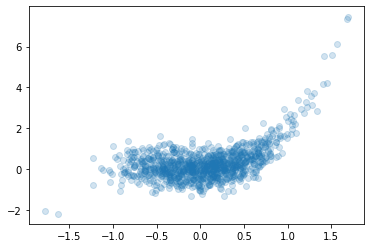

In [2]:
### Generating Random Data ###
import numpy as np
np.random.seed(1701)

def random_data(N) :
    X = np.random.randn(N)/2
    y = X**2+X**3 + 0.5*np.random.randn(N)
    return X,y
  
## Plot It ###
%matplotlib inline
import matplotlib.pyplot as plt
X,y = random_data(1000)
plt.scatter(X,y,alpha=0.2)

Note that in this case, we also know what the true value should be: it is the function
$$
f(x) = x^2 + x^3
$$
where the values have been corrupted with a gaussian noise of variance $0.25$.

## Masuring the Bias and Variance
Let's start with measuring the bias.  Recall that the bias at a point $x$ is
$$
\mathrm{Bias}(x) = f(x) - \mathbb{E}[\hat f(x)]
$$
over learned models $\hat f$ trained on independent random instances of the data.  Thus to measure this, we need only train many instances of the model on independent random synthetic data, and see how they behave.

Similarly, the variance at a point is given by
$$
\mathrm{Var}(x) = \mathrm{Var}[\hat f(x)]
$$
And is just the amount that the predictions themselves fluctuate,

### Question 1
> For the synthetic data above, train $1000$ independent decision trees on $1000$ data points.  Compute the square of the bias and variance for every point in ```np.arange(-1.4, 1.4, 0.01)``` and plot them.  Things will be much clearer if you also plot the noise at the constant value of $0.25$.
>
> Do this for every choice of ```max_depth``` in $\{1,2,4,8,16,32\}$  What do you observe?  What happens to the variance once the model begins to overfit?  Are the bias and variance constant over the entire domain?  Feel free to use ```sklearn``` for training your trees.

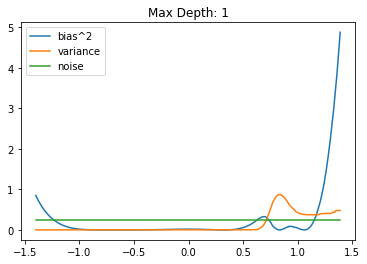

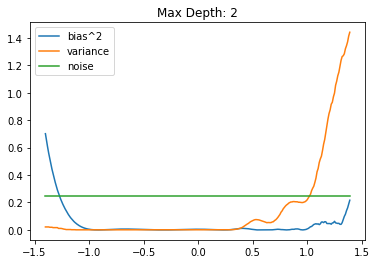

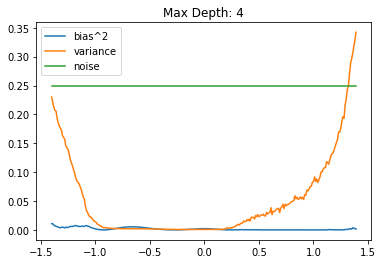

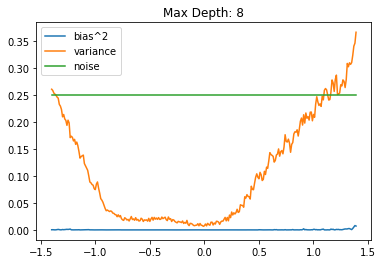

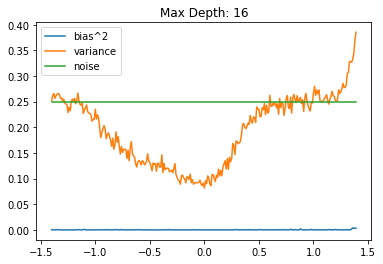

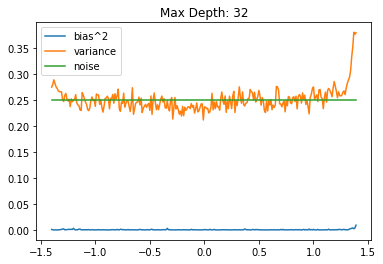

In [3]:
### Answer 1 ###

import numpy as np
from sklearn.tree import DecisionTreeRegressor

def plot_bias_var(max_depth) :
    # Get things ready
    xa = np.arange(-1.4, 1.4, 0.01)
    predictions = []
    
    # Build 1000 models and have them all predict
    
    for iteration in range(1000):
        X, y = random_data(1000)
        model = DecisionTreeRegressor(max_depth=max_depth)
        model.fit(X.reshape(-1,1),y)
        ya = model.predict(xa.reshape(-1,1))
        predictions.append(ya)
        
    # compute means and standard deviations
    means = np.mean(predictions,axis=0)
    stds = np.std(predictions,axis=0)
    bias = means - xa**2 - xa**3
    variance = stds**2
    
    # plot them
    plt.plot(xa,bias**2,label = 'bias^2')
    plt.plot(xa,variance,label = 'variance')
    plt.plot(xa,len(variance)*[0.25],label = 'noise')
    plt.legend()
    plt.title("Max Depth: {}".format(max_depth))
    plt.show()

plot_bias_var(1)
plot_bias_var(2)
plot_bias_var(4)
plot_bias_var(8)
plot_bias_var(16)
plot_bias_var(32)

### Answer 1
The bias and variance are different across the domain. The overfitting is more pronounced on the right hand side, where visually it is also more severe. The bias decreases rapidly to zero. The variance also decreases in the beginning, but then increases in the end. Note that there is a natural ceiling for the variance when overfitting, namely the level of inherent noise. If you think about it, this makes a whole lot of sense! If you are just memorizing the data, then the variance at a point is just the variance of the data you memorized there, which is just the inherent noise in the process you are modeling.

This also gives an interesting upper bound for all overfit models: The MSE of a severely overfit model will be twice the inherent noise in the model when dealing with decision trees.

### Question 2
Recall that another method we used to control overfitting was a minimum impurity needed to split a node.  Run the same experiment as above with the minimum impurites ```min_impurity_split``` in the range $\{0.05,0.10,0.15,0.20,0.25,0.30,0.35\}$.  Visually the overfitting was more uniformly spread with this method of regularization.  Does the bias variance decomposition support  this conclusion?

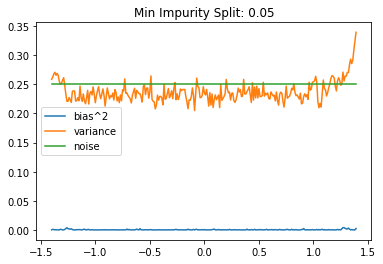

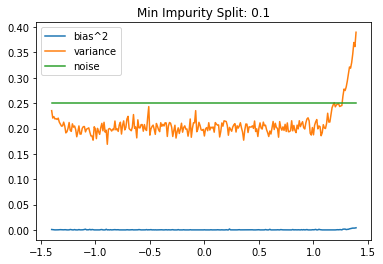

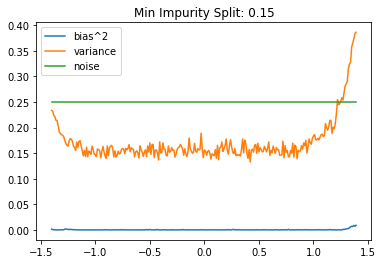

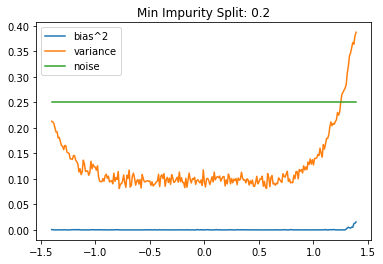

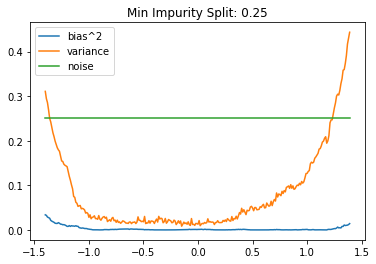

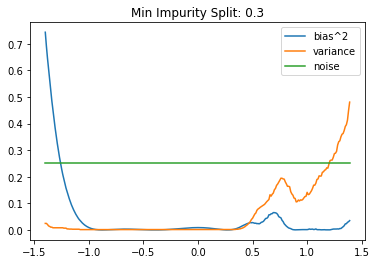

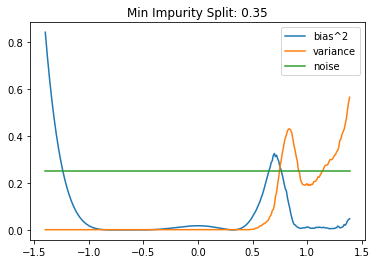

In [4]:
### Answer 2 ###
import numpy as np

from sklearn.tree import DecisionTreeRegressor

def plot_bias_var_impurity(min_impurity_decrease) :
    # Get things ready
    xa = np.arange(-1.4, 1.4, 0.01)
    predictions = []
    
    # Build 1000 models and have them all predict
    for iteration in range(1000):
        X, y = random_data(1000)
        model = DecisionTreeRegressor(min_impurity_split=min_impurity_decrease)
        model.fit(X.reshape(-1,1),y)
        ya = model.predict(xa.reshape(-1,1))
        predictions.append(ya)
    
    # compute means and standard deviations
    means = np.mean(predictions,axis=0)
    stds = np.std(predictions,axis=0)
    bias = means - xa**2 - xa**3
    variance = stds**2
    
    # plot them
    plt.plot(xa,bias**2,label = 'bias^2')
    plt.plot(xa,variance,label = 'variance')
    plt.plot(xa,len(variance)*[0.25],label = 'noise')
    plt.legend()
    plt.title("Min Impurity Split: {}".format(min_impurity_decrease))
    plt.show()
    
plot_bias_var_impurity(0.05)
plot_bias_var_impurity(0.10)
plot_bias_var_impurity(0.15)
plot_bias_var_impurity(0.20)
plot_bias_var_impurity(0.25)
plot_bias_var_impurity(0.30)
plot_bias_var_impurity(0.35)

### Answer 2

Indeed it does! In particular, if you examine say max_depth = 16 and compare with min_impurity_split = 0.15, you see that even though they have similar overall error rates, the one based on the impurity split is much more evenly spread over the domain. If this is desireable depends heavily on the task you want to complete later. Is getting the most common task right important, or do you want to make equal errors across all?

## Examining the decomposition

As a final check, let's remember where this decomposition came from we started from the mean squared error over a future data point:
$$
\mathbb{E}[(y-\hat f(\vec x))^2] = \mathrm{Bias}(\vec x)^2 + \mathrm{Var}(\hat f(\vec x)) + \mathrm{Noise}(\vec x)
$$
So all of our errors are built from three contributions: the systematic error in the bias, the variance of the model learned, and the inherent noise.  

These two sides can be approximated in two different ways.  The MSE of a learned model can be computed by training a decision tree on a dataset, and then testing its predictions on a new dataset.  Notice this is the same as averaging the left hand side over random datapoints $\vec x$.  The right hand side can be estimated as we do above, but where we take the average bias and variance at points of another new dataset.

### Question 3
> Do this test.  Train a single decision tree (with ```min_impurity_split = 0.25``` on one $1000$ point dataset.  Test the MSE on another $1000$ point dataset.  Average this $1000$ times.  This approximates the left hand side.  Then sample another $1000$ point dataset and average the bias and variance (as computed using $1000$ different $1000$ datapoint datasets) to get the right hand side (not forgetting at add the noise).  If all goes well, these two numbers should be comfortably within $0.01$ of eachother.

In [5]:
### Answer 3 ###

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

# Approximate the left hand side
ave_mse = 0
for i in range(1000) :
    X, y = random_data(1000)
    X_t, y_t = random_data(1000)
    model = DecisionTreeRegressor(min_impurity_split = 0.25)
    model.fit(X.reshape(-1,1),y)
    y_t_hat = model.predict(X_t.reshape(-1,1))
    ave_mse += mean_squared_error(y_t_hat,y_t)/1000.0

print("Average MSE is: {}".format(ave_mse))

# Approximate the right hand side
# Get things ready
xa, _ = random_data(1000)
predictions = []

# Build 1000 models and have them all predict
for iteration in range(1000):
    X, y = random_data(1000)
    model = DecisionTreeRegressor(min_impurity_split = 0.25)
    model.fit(X.reshape(-1,1),y)
    ya = model.predict(xa.reshape(-1,1))
    predictions.append(ya)

# compute means and standard deviations
means = np.mean(predictions,axis=0)
stds = np.std(predictions,axis=0)
bias = means - xa**2 - xa**3
variance = stds**2

print("Bias^2: {}, Variance: {}, Noise: {}, TOTAL: {}".format(np.mean(bias**2),np.mean(variance),0.25,np.mean(bias**2)+np.mean(variance)+0.25))
print("Difference: {}".format(ave_mse - np.mean(bias**2)-np.mean(variance)-0.25))

Average MSE is: 0.29536741268669886
Bias^2: 0.003274346634667982, Variance: 0.041095886889962026, Noise: 0.25, TOTAL: 0.29437023352463
Difference: 0.000997179162068873


## ExtraTrees
> Now we'll turn to a quick examination of the behavior of ExtraTrees on this same dataset.  Produce the same types of graphs as in problems one and two, but this time using the [ExtraTreesRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html).  Use the impurity split cutoff (```min_impurity_split```) of $0.2$.  Try it with the number of trees being $\{1,2,4,8,16,32\}$. What do you see?  If you compare a single ExtraTree with a single Decision tree with the same impurity cutoff, how to the biases and variances compare?  How about after you have averaged many such trees?  Does this agree with the storyline we saw in class:
> * Bias should increase, or stay about the same compared to a non-random decision tree
> * The bias should remain unchanged as you average more trees
> * Variance of a single tree should increase compared to a non-random decision tree
> * The variance should come in two parts, one that vanishes with averaging many trees, and one that does not
> * The variance after averaging 32 trees should be less than the variance of a single non-randomized decision tree.
>
> Finally, just train a single decision tree with ```min_impurity_split = 0.25``` and a 32 tree ensemble of ExtraTrees with the same ```min_impurity_split = 0.25``` on some training set of $1000$ points.  Do a good-ol' cross validation of both against a validation set of $1000$ more points.  How large is the improvement?  To make sure the measurement of the gain is accuracte, report the averages over $1000$ repeated experiments.

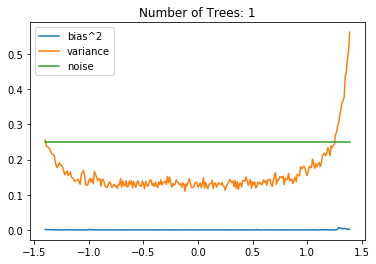

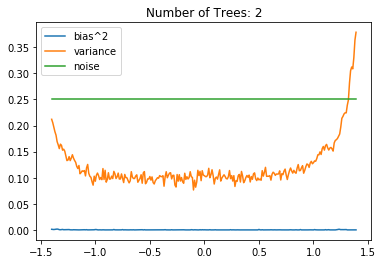

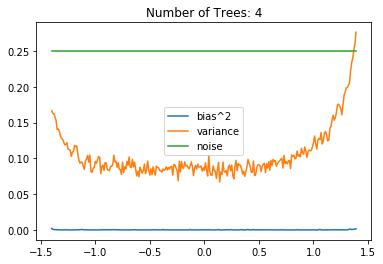

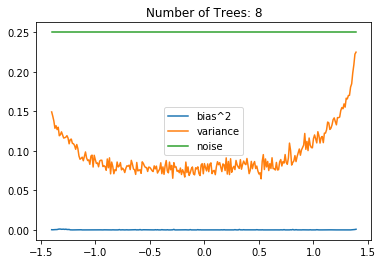

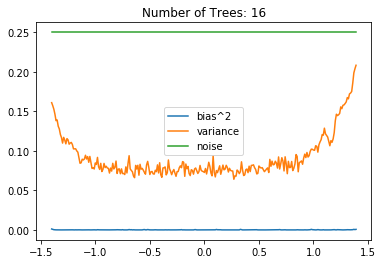

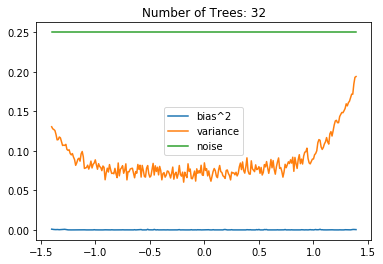

In [6]:
### Answer 4 ###

import numpy as np
from sklearn.ensemble import ExtraTreesRegressor

def plot_bias_var_n(n) :
    # Get things ready
    xa = np.arange(-1.4, 1.4, 0.01)
    predictions = []
    
    # Build 1000 models and have them all predict
    for iteration in range(1000):
        X, y = random_data(1000)
        model = ExtraTreesRegressor(n_estimators = n, min_impurity_split=0.2)
        model.fit(X.reshape(-1,1),y)
        ya = model.predict(xa.reshape(-1,1))
        predictions.append(ya)
    
    # compute means and standard deviations
    means = np.mean(predictions,axis=0)
    stds = np.std(predictions,axis=0)
    bias = means - xa**2 - xa**3
    variance = stds**2
    
    # plot them
    plt.plot(xa,bias**2,label = 'bias^2')
    plt.plot(xa,variance,label = 'variance')
    plt.plot(xa,len(variance)*[0.25],label = 'noise') 
    plt.title("Number of Trees: {}".format(n))
    plt.legend()
    plt.show()

plot_bias_var_n(1)
plot_bias_var_n(2)
plot_bias_var_n(4)
plot_bias_var_n(8)
plot_bias_var_n(16)
plot_bias_var_n(32)

In [7]:
ave_1 = 0.0
ave_2 = 0.0

for i in range(1000):
    m1 = DecisionTreeRegressor(min_impurity_split = 0.25)
    m2 = ExtraTreesRegressor(min_impurity_split = 0.25, n_estimators = 32)
    
    X, y = random_data(1000)
    X_t, y_t = random_data(1000)
    
    m1.fit(X.reshape(-1,1),y)
    m2.fit(X.reshape(-1,1),y)
    
    y_t_hat1 = m1.predict(X_t.reshape(-1,1))
    y_t_hat2 = m2.predict(X_t.reshape(-1,1))
    
    ave_1 += mean_squared_error(y_t_hat1,y_t)/1000.0
    ave_2 += mean_squared_error(y_t_hat2,y_t)/1000.0
    
print("MSE1: {}, MSE2: {}, Difference: {}".format(ave_1,ave_2,ave_1-ave_2))

MSE1: 0.29304616172532166, MSE2: 0.28086988789767087, Difference: 0.012176273827650796


### Answer 4

Indeed that does occur! If you look closely, the reason I picked this split is that in the single tree case, the variance is pegged at almost exactly 0.10 over the entire range for the single deterministic tree. If you look at where the variance curve is here, it starts our hovering comfortably above 0.10. Indeed a single ExtraTree is higher variance than a single classical decsion tree. However, As we average them, the variance decreases and ends up comfortably below 0.10 for most of the range, and below 0.25 for the entire range. This is all in exact agreement with what we hope for. In particular, the varaiance on the extremes is under much better controlled. All this results in a measurable, if minor, improvement in the MSE of about 0.01 (or about 4% of the error). Remembering that the absolute minimum possible of MSE is 0.25, this is a pretty nice improvement!

## Final Project Dataset
### Question 5
Now we turn to the final project dataset. It is up to you what you want to try, but experiment with decision trees and ExtraTrees to see what works.  Do you see significant improvement of one versus the other?  You should probably experiment on a subset of the data before trying to work with the entire set, as it is best to move quickly when trying things out, and only dig deeper once a method seems promising.

In [8]:
### Answer 5 ###

# Code Answer 5 here.